# MIE1624 Course Project

### Table of Content

### Import all packages

In [1]:
# pip install wordcloud

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk 
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

from nltk.corpus import stopwords  
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
more_stopwords = {'u', 'im', 'youd', 'youll', 'youve'}
stop_words = stopwords.union(more_stopwords)

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report,accuracy_score

[nltk_data] Downloading package wordnet to /Users/ruiyang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ruiyang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ruiyang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruiyang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Part 1 – Sentiment modeling:

## 1.1 Import sentiment data

In [3]:
# from google.colab import files
# uploaded = files.upload()

In [4]:
# import data
sentiment = pd.read_csv('sentiment_analysis.csv')
sentiment

ID                                               text  label
0       7.680980e+17  Josh Jenkins is looking forward to TAB Breeder...      1
1       7.680980e+17  RT @MianUsmanJaved: Congratulations Pakistan o...      1
2       7.680980e+17  RT @PEPalerts: This September, @YESmag is taki...      1
3       7.680980e+17  RT @david_gaibis: Newly painted walls, thanks ...      1
4       7.680980e+17  RT @CedricFeschotte: Excited to announce: as o...      1
...              ...                                                ...    ...
550386  8.046170e+17  @goddesses_o I can't stop watching her...mm. M...      0
550387  8.046180e+17  Poor old Tom Odell doesn't look like he would ...      0
550388  8.046180e+17  #antsmasher I smashed  7 ants in this awesome ...      1
550389  8.046180e+17  @LizHudston @KymWyllie @Evasmiless @meanBok @l...      1
550390  8.046190e+17  Bixbeat Mixtape Vol.2 is here with great artis...      1

[550391 rows x 3 columns]

## 1.2 Basic feature extraction

In [5]:
def feature_extract(df):
    # Number of words
    df["Number_of_words"] = df["text"].apply(lambda x: len(x.split()))
    # Number of characters
    df["Number_of_characters"] = df["text"].apply(lambda x: len(x))
    # Average word length
    average_word_length = []
    for i in df["text"]:
        words = i.split()
        average_word_length.append(sum(len(word) for word in words) / len(words))
    df["Average_word_length"] = average_word_length
    # Number of stop words
    df['Number_of_stopwords'] = df['text'].apply(lambda x: len([w for w in x.split() if w in stop_words]))

In [6]:
# apply basic feature extraction function
feature_extract(sentiment)
sentiment

ID                                               text  \
0       7.680980e+17  Josh Jenkins is looking forward to TAB Breeder...   
1       7.680980e+17  RT @MianUsmanJaved: Congratulations Pakistan o...   
2       7.680980e+17  RT @PEPalerts: This September, @YESmag is taki...   
3       7.680980e+17  RT @david_gaibis: Newly painted walls, thanks ...   
4       7.680980e+17  RT @CedricFeschotte: Excited to announce: as o...   
...              ...                                                ...   
550386  8.046170e+17  @goddesses_o I can't stop watching her...mm. M...   
550387  8.046180e+17  Poor old Tom Odell doesn't look like he would ...   
550388  8.046180e+17  #antsmasher I smashed  7 ants in this awesome ...   
550389  8.046180e+17  @LizHudston @KymWyllie @Evasmiless @meanBok @l...   
550390  8.046190e+17  Bixbeat Mixtape Vol.2 is here with great artis...   

        label  Number_of_words  Number_of_characters  Average_word_length  \
0           1               13                   114             7.846154   
1           1               15                   140             8.400000   
2           1               20                   140             6.050000   
3           1               18                   139             6.722222   
4           1               18                   130             6.277778   
...       ...              ...                   ...                  ...   
550386      0                8                    76             8.625000   
550387      0               16                    96             5.062500   
550388      1               11                   107             8.727273   
550389      1               13                   130             9.076923   
550390      1               15                   136             8.133333   

        Number_of_stopwords  
0                         2  
1                         5  
2                         6  
3                         4  
4                         6  
...                     ...  
550386                    0  
550387                    5  
550388                    2  
550389                    2  
550390                    4  

[550391 rows x 7 columns]

## 1.3 Basic text preprocessing

In [7]:
def text_preprocess(df):
    # Remove mentioned username 
    df["text"] = df["text"].apply(lambda x: re.sub("@[A-Za-z0-9_]+","", x))
    # Remove hashtag and save it in a new column
    df['hashtag'] = df["text"].apply(lambda x: re.findall("#([a-zA-Z0-9_]{1,50})", x))
    df["text"] = df["text"].apply(lambda x: re.sub("#[A-Za-z0-9_]+","", x))
    # Remove 'RT'
    df["text"] = df["text"].apply(lambda x: re.sub(r'\bRT\b','', x))
    # Remove URL
    df["text"] = df["text"].apply(lambda x: re.sub(r"http\S+", "", x))
    # Remove emoji
    df["text"] = df["text"].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
    # Remove punctuation
    df["text"] = df["text"].apply(lambda x: re.sub(r"[^\w\s]","", x))
    # remove number
    df["text"] = df["text"].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
    # Lower casing
    df["text"] = df["text"].apply(lambda x: x.lower())
    # Remove stopwords
    df['text'] = df['text'].apply(lambda x: ' '.join(
        [word for word in x.split() if word not in stop_words]))
    # Tokenization: tokenizers divide strings into lists of substrings
    df['tokenized'] = df['text'].apply(lambda x: nltk.word_tokenize(x))
    # Lemmatization: considers the context and converts the word to its meaningful base form
    df['lemmatization'] = df['tokenized'].apply(lambda x: ' '.join(
        [wordnet_lemmatizer.lemmatize(word) for word in x]))
    # Drop duplicated samples, after cleaning
    # df.drop_duplicates(subset='lemmatization',inplace=True)

In [8]:
# apply text_preprocess function
text_preprocess(sentiment)
sentiment

ID                                               text  \
0       7.680980e+17  josh jenkins looking forward tab breeders crow...   
1       7.680980e+17       congratulations pakistan becoming world odds   
2       7.680980e+17  september taking maine mendozas surprise thank...   
3       7.680980e+17  newly painted walls thanks million custodial p...   
4       7.680980e+17  excited announce july feschotte lab relocating...   
...              ...                                                ...   
550386  8.046170e+17                           cant stop watching hermm   
550387  8.046180e+17  poor old tom odell doesnt look like would know...   
550388  8.046180e+17                    smashed ants awesome gamehjfjfi   
550389  8.046180e+17                            morning girls wonderful   
550390  8.046190e+17        bixbeat mixtape great artiste join movement   

        label  Number_of_words  Number_of_characters  Average_word_length  \
0           1               13                   114             7.846154   
1           1               15                   140             8.400000   
2           1               20                   140             6.050000   
3           1               18                   139             6.722222   
4           1               18                   130             6.277778   
...       ...              ...                   ...                  ...   
550386      0                8                    76             8.625000   
550387      0               16                    96             5.062500   
550388      1               11                   107             8.727273   
550389      1               13                   130             9.076923   
550390      1               15                   136             8.133333   

        Number_of_stopwords                               hashtag  \
0                         2                                    []   
1                         5  [No1TestTeam, JI_PakZindabadRallies]   
2                         6                                    []   
3                         4                            [EC_proud]   
4                         6                                    []   
...                     ...                                   ...   
550386                    0                                    []   
550387                    5                                    []   
550388                    2                          [antsmasher]   
550389                    2                              [Friday]   
550390                    4                                    []   

                                                tokenized  \
0       [josh, jenkins, looking, forward, tab, breeder...   
1       [congratulations, pakistan, becoming, world, o...   
2       [september, taking, maine, mendozas, surprise,...   
3       [newly, painted, walls, thanks, million, custo...   
4       [excited, announce, july, feschotte, lab, relo...   
...                                                   ...   
550386                      [cant, stop, watching, hermm]   
550387  [poor, old, tom, odell, doesnt, look, like, wo...   
550388               [smashed, ants, awesome, gamehjfjfi]   
550389                        [morning, girls, wonderful]   
550390  [bixbeat, mixtape, great, artiste, join, movem...   

                                            lemmatization  
0       josh jenkins looking forward tab breeder crown...  
1             congratulation pakistan becoming world odds  
2       september taking maine mendozas surprise thank...  
3       newly painted wall thanks million custodial pa...  
4       excited announce july feschotte lab relocating...  
...                                                   ...  
550386                           cant stop watching hermm  
550387  poor old tom odell doesnt look like would know...  
550388                     smashed ant awesome gamehjfjfi  
550389                        

## 1.4 Split data into train and test dataset

In [9]:
# Split into train and test dataset
X = sentiment.lemmatization
y = sentiment.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

## 1.5 TF-IDF

TF-IDF for a word in a document is calculated by multiplying two different metrics:

The term frequency of a word in a document. There are several ways of calculating this frequency, with the simplest being a raw count of instances a word appears in a document. Then, there are ways to adjust the frequency, by length of a document, or by the raw frequency of the most frequent word in a document.

The inverse document frequency of the word across a set of documents. This means, how common or rare a word is in the entire document set. The closer it is to 0, the more common a word is. This metric can be calculated by taking the total number of documents, dividing it by the number of documents that contain a word, and calculating the logarithm.

In [10]:
vectorizer = TfidfVectorizer(max_features=2000, token_pattern=r'\b[a-zA-Z]{3,}\b')  
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)
X_train = pd.DataFrame(X_train.toarray(),columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(X_test.toarray(),columns = vectorizer.get_feature_names_out())

In [11]:
X_train

ability  able  absolute  absolutely  abt  abuse  accept  access  \
0           0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
1           0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
2           0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
3           0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
4           0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
...         ...   ...       ...         ...  ...    ...     ...     ...   
385268      0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
385269      0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
385270      0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
385271      0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
385272      0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   

        accident  account  ...  yesterday  yet  york  young  youre  youth  \
0            0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
1            0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
2            0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
3            0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
4            0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
...          ...      ...  ...        ...  ...   ...    ...    ...    ...   
385268       0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
385269       0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
385270       0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
385271       0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
385272       0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   

        youtube  yummy  zombie  zoo  
0           0.0    0.0     0.0  0.0  
1           0.0    0.0     0.0  0.0  
2           0.0    0.0     0.0  0.0  
3           0.0    0.0     0.0  0.0  
4           0.0    0.0     0.0  0.0  
...         ...    ...     ...  ...  
385268      0.0    0.0     0.0  0.0  
385269      0.0    0.0     0.0  0.0  
385270      0.0    0.0     0.0  0.0  
385271      0.0    0.0     0.0  0.0  
385272      0.0    0.0     0.0  0.0  

[385273 rows x 2000 columns]

## 1.6 Choose Optimal Model by Tuning Hyper-parameters

### 1.6.1  Logistic Regression

Hyperparameters tuned in logistic regression is C and solver. 
- C represents the the inverse of regularization term. A high value of C tells the model to give high weight to the training data, and a lower weight to the complexity penalty. A low value tells the model to give more weight to this complexity penalty at the expense of fitting to the training data. Basically, a high C means "Trust this training data a lot", while a low value says "This data may not be fully representative of the real world data, so if it's telling you to make a parameter really large, don't listen to it".
- For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones. For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss. ‘liblinear’ is limited to one-versus-rest schemes.

In [12]:
# fit the best model
LogReg_clf_best = LogisticRegression(C=20, solver ='saga', max_iter=10000)
LogReg_clf_best = LogReg_clf_best.fit(X_train, y_train)
LogReg_clf_pred_train = LogReg_clf_best.predict(X_train)
LogReg_clf_pred_test = LogReg_clf_best.predict(X_test)

In [13]:
print('The best training accuracy score: {}%'.format(round(accuracy_score(y_train, LogReg_clf_pred_train)*100,2)))
print('The best test accuracy score: {}%'.format(round(accuracy_score(y_test, LogReg_clf_pred_test)*100,2)))

The best training accuracy score: 95.61%
The best test accuracy score: 95.43%


### 1.6.2  Multinomial Naive Bayes
- The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). It calculates each tag's likelihood for a given sample and outputs the tag with the greatest chance. It is computationally very efficient and easy to implement. 
- Hyperparameters tuned in logistic regression is Alpha. Alphais the additive (Laplace/Lidstone) smoothing parameter.


In [14]:
# fit the best model
nb_clf_best = MultinomialNB(alpha=0.01)
nb_clf_best = nb_clf_best.fit(X_train, y_train)
nb_clf_pred_train = nb_clf_best.predict(X_train)
nb_clf_pred_test = nb_clf_best.predict(X_test)

In [15]:
print('The best training accuracy score: {}%'.format(round(accuracy_score(y_train, nb_clf_pred_train)*100,2)))
print('The best test accuracy score: {}%'.format(round(accuracy_score(y_test, nb_clf_pred_test)*100,2)))

The best training accuracy score: 92.02%
The best test accuracy score: 91.92%


### 1.6.3 Support Vector Machine

In [16]:
# fit the best model
svm_best = LinearSVC(C=1).fit(X_train, y_train)
svm_pred_train = svm_best.predict(X_train)
svm_pred_test = svm_best.predict(X_test)

In [17]:
print('The best training accuracy score: {}%'.format(round(accuracy_score(y_train, svm_pred_train)*100,2)))
print('The best test accuracy score: {}%'.format(round(accuracy_score(y_test, svm_pred_test)*100,2)))

The best training accuracy score: 95.57%
The best test accuracy score: 95.38%


### 1.6.4 Random Forest

In [18]:
#fit the best model
rf_best = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)
rf_pred_train = rf_best.predict(X_train)
rf_pred_test = rf_best.predict(X_test)

In [19]:
print('The best training accuracy score: {}%'.format(round(accuracy_score(y_train, rf_pred_train)*100,2)))
print('The best test accuracy score: {}%'.format(round(accuracy_score(y_test, rf_pred_test)*100,2)))

The best training accuracy score: 99.27%
The best test accuracy score: 95.19%


### 1.8 Results

|Model|Training Accuracy|Test Accuracy|Hyperparameters|
|:----------|:----------------|:------------|:------------|
|Logistic Regression|95.61%|95.43%|{'C': 20, 'solver': 'saga'}|
|Multinomial Naive Bayes|92.02%|91.92%|{'alpha': 0.01}|
|Support Vector Machine|95.57%|95.38%|{'C': 1}|
|Random Forest|99.27%|95.17%|{'n_estimators':100}|


**Conclusion**

By comparing all models, we can found that Logistic Regression, Support Vector Machine and Random Forest all have great test accuracy. We will apply these four models in the further analysis.

# Part 2 – Sentiment classification:

## 2.1 Suggested dataset -'0819_UkraineCombinedTweetsDeduped'
* Tweets analysis (sentiment, topic, personnel & resource losses) https://omkargawade.medium.com/russia-ukraine-war-tweets-nlp-analysis-bd10b352316c.

### 2.1.1 Import and extract data

In [20]:
# Import data
Test_dataset_1 = pd.read_csv('0819_UkraineCombinedTweetsDeduped.csv')

# Notice there is a column named 'language'
print('There are {} kinds of language in this dataset.'.format(Test_dataset_1.language.value_counts().shape[0]))

There are 59 kinds of language in this dataset.


In [21]:
# Filter out the tweets not writen in English.
tweets_eng =  Test_dataset_1[Test_dataset_1.language == 'en'].text

# Extract the text of tweets in English, which will be used for training.
test_data_1 = pd.DataFrame(tweets_eng, columns = ['text'])

### 2.1.2 Basic feature extraction and Basic text preprocessing

In [22]:
# apply basic feature extraction function
feature_extract(test_data_1)

In [23]:
# apply text preprocessing function
text_preprocess(test_data_1)
test_data_1

text  Number_of_words  \
0      dear vaccine advocate take mrna shot boosters ...               40   
2      animal shelter dogs cats need help raising fun...               30   
3      welcome shelter located ukraine kyiv shelter n...               32   
5      good news may missed first shipment wheat oper...               35   
6           opinion ukraine war also fought language cnn               18   
...                                                  ...              ...   
47986      russian tank hits ukrainian mine date unknown               14   
47987  turks putins handpicked mediators continue thu...               32   
47989  everything usual another russian government pe...               32   
47990                                twisted firestarter                3   
47993  people say us better shape trump office l remi...               30   

       Number_of_characters  Average_word_length  Number_of_stopwords  \
0                       304             6.575000                    7   
2                       300             9.000000                    4   
3                       300             8.375000                    5   
5                       226             5.428571                   10   
6                       153             7.333333                    3   
...                     ...                  ...                  ...   
47986                   120             7.571429                    1   
47987                   297             8.312500                    6   
47989                   294             8.218750                    8   
47990                    34            10.666667                    0   
47993                   167             4.600000                   13   

                                                 hashtag  \
0      [Pfizer, AstraZeneca, Moderna, NWO, Agenda2030...   
2      [Ukraine, Patreon, dogsoftwitter, Shelter, Dog...   
3      [Ukraine, Kyiv, Shelter, Dogs, Cats, Pets, Dog...   
5                          [humanitarian, Ukraine, food]   
6      [Ukraine, Freedom, KeepKyivFree, Zelenskyy, Fu...   
...                                                  ...   
47986         [RussianUkrainianWar, UkraineWar, Ukraine]   
47987                   [UkraineWar, US, UN, EU, Cyprus]   
47989                          [RussiaIsATerroristState]   
47990                                                 []   
47993                                  [Biden, BlueWave]   

                                               tokenized  \
0      [dear, vaccine, advocate, take, mrna, shot, bo...   
2      [animal, shelter, dogs, cats, need, help, rais...   
3      [welcome, shelter, located, ukraine, kyiv, she...   
5      [good, news, may, missed, first, shipment, whe...   
6      [opinion, ukraine, war, also, fought, language...   
...                                                  ...   
47986  [russian, tank, hits, ukrainian, mine, date, u...   
47987  [turks, putins, handpicked, mediators, continu...   
47989  [everything, usual, another, russian, governme...   
47990                             [twisted, firestarter]   
47993  [people, say, us, better, shape, trump, office...   

                                           lemmatization  
0      dear vaccine advocate take mrna shot booster k...  
2      animal shelter dog cat need help raising fund ...  
3      welcome shelter located ukraine kyiv shelter n...  
5      good news may missed first shipment wheat oper...  
6           opinion ukraine war also fought language cnn  
...                                                  ...  
47986       russian tank hit ukrainian mine date unknown  
47987  turk putin handpicked mediator continue thumb ...  
47989  everything usual another russian government pe...  
47990                                twisted firestarter  
47993  people say u better shape trump office l remin...  

[23179 rows x 8 columns]

### 2.1.3 TF-IDF

In [24]:
# TF_IDF
test_data_1_lem = test_data_1['lemmatization']
test_data_1_try = vectorizer.transform(test_data_1_lem)
test_data_1_try= pd.DataFrame(test_data_1_try.toarray(), columns = vectorizer.get_feature_names_out())

### 2.1.4 Pre-trained model from Python libraries - `SentimentIntensityAnalyzer`
Before performing our models, perform the Pre-trained model from Python libraries first.
 * With this model, we could get 3 outputs: Negative/ Neutral/ Positive.
 * Label them with 'a','b','c' respectively.

In [25]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
  
sid = SentimentIntensityAnalyzer()
def vader_func(m):
    return (sid.polarity_scores(m)['compound'])

#Label as 'a'/'b'/'c'
test_data_1['Sentiment_score'] = test_data_1['lemmatization'].apply(
    lambda x:vader_func(x))# apply pretrained model to the tokenized text
test_data_1['type'] = test_data_1['Sentiment_score'].apply(
    lambda y: 'c' if (y>0) else('a' if (y<0) else 'b'))# decide model's label based on scores

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ruiyang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [26]:
print('Shape of test_data_1:', test_data_1.shape)
test_data_1['type'].value_counts()

Shape of test_data_1: (23179, 10)


c    8838
a    8647
b    5694
Name: type, dtype: int64

### 2.1.5 Our models for whole dataset
After applying the pre-trained model from Python libraries, we are going to apply our models.

Methodology: Lable samples to Negative, Neutral or Positive based on their probability to 1.
#### 2.1.5.1 Logistic Regression 

In [27]:
# Define probability distibution plot
import seaborn as sns
def prob_distribution_plot(model,X_test):
    y_test_proba = model.predict_proba(X_test)
    plt.figure(figsize=(5,5))
    sns.displot(data = y_test_proba[:,1])
    plt.title('Distribution of probabilities to positive')
    plt.xlabel('Probability to positive(0 to 1)')
    plt.ylabel('Counts of samples')
    plt.show()

<Figure size 360x360 with 0 Axes>

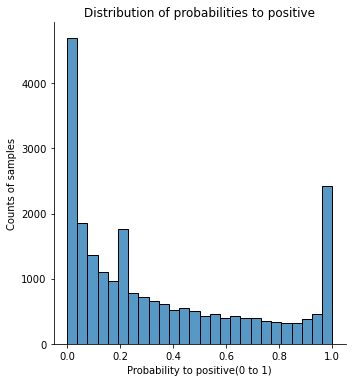

In [28]:
# Plot the probabiliy distribution, by LogReg on our first pick of the datasets
prob_distribution_plot(LogReg_clf_best,test_data_1_try)

From the plot above, we can see that there are some samples predicted to positive with probability between 0.4 to 0.6.
Therefore, we decided to seperate them to a,b,c with respect to negative, neutral, and positive as following.
  * If probability_to_positive < 0.4, consider them as negative with label 'a'
  * If 0.4 <= probability_to_positive <= 0.6 , consider them as neutral with label 'b'
  * If probability_to_positive >0.6, consider them as neutral with label 'c'

In [29]:
# assign label a/b/c to each data point
prob_to_positive = LogReg_clf_best.predict_proba(test_data_1_try)[:,1]
label_try = []
for i in range(len(prob_to_positive)):
    label_try.append('a' if prob_to_positive[i] <0.4 else 'b' if 0.4 <= prob_to_positive[i] <= 0.6 else 'c')
    
# Compute the accuracy score of our log-reg model with the pre-trained Vader model.
print('The accuracy score: {}%'.format(round(accuracy_score(label_try, np.array(test_data_1['type']))*100,2)))

The accuracy score: 54.72%


#### 2.1.5.2 Multinomial Naive Bayes

In [30]:
# assign label a/b/c to each data point
prob_to_positive = nb_clf_best.predict_proba(test_data_1_try)[:,1]
label_try = []
for i in range(len(prob_to_positive)):
    label_try.append('a' if prob_to_positive[i] <0.4 else 'b' if 0.4 <= prob_to_positive[i] <= 0.6 else 'c')
    
# Compute the accuracy score of our Multinomial Naive Bayes model with the pre-trained Vader model.
print('The accuracy score: {}%'.format(round(accuracy_score(label_try, np.array(test_data_1['type']))*100,2)))

The accuracy score: 53.73%


#### 2.1.5.3 Support Vector Machine - LinearSVC 

LinearSVC does not support probability estimation as it is based on liblinear. Therefore, we cannot label multiple classes for this dataset by probability.

#### 2.1.5.4 Random Forest

In [31]:
# assign label a/b/c to each data point
prob_to_positive = rf_best.predict_proba(test_data_1_try)[:,1]
label_try = []
for i in range(len(prob_to_positive)):
    label_try.append('a' if prob_to_positive[i] <0.4 else 'b' if 0.4 <= prob_to_positive[i] <= 0.6 else 'c')
    
# Compute the accuracy score of our Random Forests model with the pre-trained Vader model.
print('The accuracy score: {}%'.format(round(accuracy_score(label_try, np.array(test_data_1['type']))*100,2)))

The accuracy score: 52.49%


### Results for  '0819_UkraineCombinedTweetsDeduped' dataset

|Model|Test Accuracy|Hyperparameters|
|:----------|:------------|:------------|
|Logistic Regression|54.72%|{'C': 20, 'solver': 'saga'}|
|Multinomial Naive Bayes|53.75%|{'alpha': 0.01}|
|Support Vector Machine|NA|NA|
|Random Forest|52.47%|{'n_estimators':100}|



#### Conclusion: 
Since in part 3 we especially looking at posts/tweets with negative and positive sentiment, as posts/tweets with neutral sentiment are less informative, we consider to drop the samples if they are predicted as Neutral by the pre-trained model - Vader funtion.
* Drop Neutral
* Label positive ==> 1 
* Label negative ==> 0

### 2.1.6 Our models for the reduced dataset (drop neutral samples)
We only keep the samples predicted as positive/ negative by pre-trained model `SentimentIntensityAnalyzer`.

Discarding the smaples predicted as neutral.

In [32]:
pd.options.mode.chained_assignment = None

test_data_1 = test_data_1[test_data_1['type']!='b']
test_data_1['type'] = test_data_1['type'].replace(['a'],0)
test_data_1['type'] = test_data_1['type'].replace(['c'],1)

# Lets see the total numbers of positive and negative predicted by the pre-trained model.
print('Shape of test_data_1:', test_data_1.shape)
test_data_1['type'].value_counts()

Shape of test_data_1: (17485, 10)


1    8838
0    8647
Name: type, dtype: int64

Positive and Negative are quite balanced.
####  TF_IDF on reduced dataset

In [33]:
# TF_IDF after discarding the smaples predicted as neutral 
test_data_1_lem = test_data_1['lemmatization']
test_data_1_final = vectorizer.transform(test_data_1_lem)
test_data_1_final= pd.DataFrame(test_data_1_final.toarray(),columns = vectorizer.get_feature_names_out())

In [34]:
test_data_1_final

ability  able  absolute  absolutely  abt  abuse  accept  access  \
0          0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
1          0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
2          0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
3          0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
4          0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
...        ...   ...       ...         ...  ...    ...     ...     ...   
17480      0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
17481      0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
17482      0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
17483      0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
17484      0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   

       accident  account  ...  yesterday  yet  york  young  youre  youth  \
0           0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
1           0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
2           0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
3           0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
4           0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
...         ...      ...  ...        ...  ...   ...    ...    ...    ...   
17480       0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
17481       0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
17482       0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
17483       0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
17484       0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   

       youtube  yummy  zombie  zoo  
0          0.0    0.0     0.0  0.0  
1          0.0    0.0     0.0  0.0  
2          0.0    0.0     0.0  0.0  
3          0.0    0.0     0.0  0.0  
4          0.0    0.0     0.0  0.0  
...        ...    ...     ...  ...  
17480      0.0    0.0     0.0  0.0  
17481      0.0    0.0     0.0  0.0  
17482      0.0    0.0     0.0  0.0  
17483      0.0    0.0     0.0  0.0  
17484      0.0    0.0     0.0  0.0  

[17485 rows x 2000 columns]

#### 2.1.6.1 Logistics Regression model on the reduced dataset

In [35]:
LogReg_clf_pred_test_1 = LogReg_clf_best.predict(test_data_1_final)

# Compare the accuracy of logistic model on the reduced dataset with the pretrained model
print('The accuracy score: {}%'.format(round(
    accuracy_score(LogReg_clf_pred_test_1, np.array(test_data_1['type']).astype(int))*100,2)))

The accuracy score: 72.65%


#### 2.1.6.2 Multinomial Naive Bayes model on the reduced dataset.

In [36]:
nb_clf_pred_test_1 = nb_clf_best.predict(test_data_1_final)

#compare the accuracy of nb model with pretrained model
print('The accuracy score: {}%'.format(round(
    accuracy_score(np.array(test_data_1['type']).astype(int), nb_clf_pred_test_1.astype(int))*100,2)))

The accuracy score: 72.33%


#### 2.1.6.3 Support Vector Machine - LinearSVC model on the reduced dataset.

In [37]:
svm_clf_pred_test_1 = svm_best.predict(test_data_1_final)

#compare the accuracy of svm model with pretrained model
print('The accuracy score: {}%'.format(round(
    accuracy_score(np.array(test_data_1['type']).astype(int), svm_clf_pred_test_1.astype(int))*100,2)))

The accuracy score: 72.66%


#### 2.1.6.4 Random Forest model on the reduced dataset.

In [38]:
rf_clf_pred_test_1 = rf_best.predict(test_data_1_final)
#compare the accuracy of rf model with pretrained model
print('The accuracy score: {}%'.format(round(
    accuracy_score(np.array(test_data_1['type']).astype(int), rf_clf_pred_test_1.astype(int))*100,2)))

The accuracy score: 69.69%


### Results for  '0819_UkraineCombinedTweetsDeduped' reduced dataset

|Model|Test Accuracy|Hyperparameters|
|:----------|:------------|:------------|
|Logistic Regression|72.65%|{'C': 20, 'solver': 'saga'}|
|Multinomial Naive Bayes|72.33%|{'alpha': 0.01}|
|Support Vector Machine|72.66%|{'C': 1}|
|Random Forest|69.35%|{'n_estimators':100}|


## 2.2 Our own dataset extracted from Twitter

### 2.2.1 Extract data from Twitter and save it as csv file

In [39]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

#https://stackoverflow.com/questions/73485659/scrape-tweets-from-a-list-of-hashtags-using-snscrape
def tweet_scraper(query, n_tweet):
    attributes_container = []
    max_tweet = n_tweet
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
        if i>max_tweet:
            break
        attributes_container.append(tweet.rawContent)
    return pd.DataFrame(attributes_container, columns=["text"])

### 2.2.2 Import presaved data

In [40]:
# import presaved data
test_data_2 = pd.read_csv('war_tweets.csv')
test_data_2

text
0      Ukraine War New Drone Footage 2022! Ukrainian ...
1      Monday, November 14. Russia’s War On Ukraine: ...
2      Monday, November 14. Russia’s War On Ukraine: ...
3      the provisions that must be in such a treaty i...
4      The end goal for us was "we don't want to touc...
...                                                  ...
19998  #Ukraine to get 250 M1117 Guardian Armored Sec...
19999  @kwekumoles @todd_boehly Lemme pretend I didn'...
20000  New Video Upload : The Russia vs. Ukraine War ...
20001  Russia Ukraine war: Russian wives defy militar...
20002  New Video Upload : The Russia vs. Ukraine War ...

[20003 rows x 1 columns]

### 2.2.3 Basic feature extraction and Basic text preprocessing

In [41]:
# apply basic feature extraction function
feature_extract(test_data_2)

In [42]:
# apply text_preprocess function
text_preprocess(test_data_2)

### 2.2.4 Pre-trained model from Python libraries - `SentimentIntensityAnalyzer`
Before performing our models, perform the Pre-trained model from Python libraries first.
 * With this model, we could get 3 outputs: 0 / Neutral / 1.

In [43]:
# Use pre-trained model to reduce dataset
test_data_2['Sentiment_score'] = test_data_2['lemmatization'].apply(
    lambda x:vader_func(x))# apply pretrained model to the tokenized text
test_data_2['type'] = test_data_2['Sentiment_score'].apply(
    lambda y: 1 if (y>0) else(0 if (y<0) else 'Neutral'))# decide model's label based on scores

### 2.2.5 TF-IDF

* Reduce the dataset, only keep the samples preidcted as Positive or Negative by the pre-trained model.
* Perform the TF-IDF on the reduced dataset.

In [44]:
test_data_2 = test_data_2[test_data_2['type']!='Neutral'] # drop neutral tweets
print('Shape of test_data_2:', test_data_2.shape)

Shape of test_data_2: (19564, 10)


In [45]:
# Perform the TF-IDF on the reduced dataset
test_data_2_lem = test_data_2['lemmatization']
test_data_2_final = vectorizer.transform(test_data_2_lem)
test_data_2_final= pd.DataFrame(test_data_2_final.toarray(),columns = vectorizer.get_feature_names_out())

In [46]:
test_data_2_final

ability  able  absolute  absolutely  abt  abuse  accept  access  \
0          0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
1          0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
2          0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
3          0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
4          0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
...        ...   ...       ...         ...  ...    ...     ...     ...   
19559      0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
19560      0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
19561      0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
19562      0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   
19563      0.0   0.0       0.0         0.0  0.0    0.0     0.0     0.0   

       accident  account  ...  yesterday  yet  york  young  youre  youth  \
0           0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
1           0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
2           0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
3           0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
4           0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
...         ...      ...  ...        ...  ...   ...    ...    ...    ...   
19559       0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
19560       0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
19561       0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
19562       0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   
19563       0.0      0.0  ...        0.0  0.0   0.0    0.0    0.0    0.0   

       youtube  yummy  zombie  zoo  
0          0.0    0.0     0.0  0.0  
1          0.0    0.0     0.0  0.0  
2          0.0    0.0     0.0  0.0  
3          0.0    0.0     0.0  0.0  
4          0.0    0.0     0.0  0.0  
...        ...    ...     ...  ...  
19559      0.0    0.0     0.0  0.0  
19560      0.0    0.0     0.0  0.0  
19561      0.0    0.0     0.0  0.0  
19562      0.0    0.0     0.0  0.0  
19563      0.0    0.0     0.0  0.0  

[19564 rows x 2000 columns]

### 2.2.6 Our models for the reduced dataset (drop neutral samples)
After applying the pre-trained model from Python libraries, we are going to apply our models.

#### 2.2.6.1 Logistic Regression model on the reduced dataset

In [47]:
#Apply logistic model on the samples predicted as positive or negative by the Vader function
LogReg_clf_pred_test_2 = LogReg_clf_best.predict(test_data_2_final)

#Compare the accuracy of our logistic model with the pretrained model, Vader
print('The accuracy score: {}%'.format(round(
    accuracy_score(np.array(test_data_2['type']).astype(int), LogReg_clf_pred_test_2)*100,2)))

The accuracy score: 84.78%


####  2.2.6.2 Multinomial Naive Bayes model on the reduced dataset 

In [48]:
nb_clf_pred_test_2 = nb_clf_best.predict(test_data_2_final)

#Compare the accuracy of nb model with pretrained model
print('The accuracy score: {}%'.format(round(
    accuracy_score(np.array(test_data_2['type']).astype(int), nb_clf_pred_test_2.astype(int))*100,2)))

The accuracy score: 79.63%


####  2.2.6.3 Support Vector Machine - LinearSVC model  model on the reduced dataset.

In [49]:
svm_clf_pred_test_2 = svm_best.predict(test_data_2_final)

#Compare the accuracy svm model with pretrained model
print('The accuracy score: {}%'.format(round(
    accuracy_score(np.array(test_data_2['type']).astype(int), svm_clf_pred_test_2.astype(int))*100,2)))

The accuracy score: 84.45%


####  2.2.6.4 Random Forest model on the reduced dataset.

In [50]:
rf_clf_pred_test_2 = rf_best.predict(test_data_2_final)

#Compare the accuracy of rf model with pretrained model
print('The accuracy score: {}%'.format(round(
    accuracy_score(np.array(test_data_2['type']).astype(int), rf_clf_pred_test_2.astype(int))*100,2)))

The accuracy score: 79.7%


### Results for  'war_tweets' dataset

|Model|Test Accuracy|Hyperparameters|
|:----------|:------------|:------------|
|Logistic Regression|84.78%|{'C': 20, 'solver': 'saga'}|
|Multinomial Naive Bayes|79.63%|{'alpha': 0.01}|
|Support Vector Machine|84.45%|{'C': 1}|
|Random Forest|79.65%|{'n_estimators':100}|


# Part 3 - Factor and topics identification via Machine Learning

We use the prediction outcome of pre-trained model in this part to ensure our analysis is accurate.

## 3.1 Merge two Ukraine and Russian war dataframes

In [51]:
#merge two dataframes because they both related to Ukraine and Russian war
merge_df = pd.concat([test_data_1, test_data_2], axis=0)
#reset the index of merged dataframe
merge_df = merge_df.reset_index(drop=True)

## 3.2 Topic Detection with LDA

In [52]:
#import CountVectorizer and LatentDirichletAllocation from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

### 3.2.1 Topics of negative sentiment

In [53]:
#select type 0 (negative) and create a new dataframe
negative_df =  merge_df[merge_df['type'] == 0]
#rest the index of the negative dataframe
negative_df =  negative_df.reset_index(drop=True)

In [54]:
#importing stopwords
stopwords = nltk.corpus.stopwords.words('english')
#creating an instance of CountVectorizer
ct = CountVectorizer(max_df = 95, min_df = 10, stop_words = stopwords)
#fit transform the text variable using CountVectorizer
dtm = ct.fit_transform(negative_df['lemmatization'])

In [55]:
#creating an instance for LDA and fit the sparse matrix
LDA = LatentDirichletAllocation(n_components=8, random_state=101,learning_method="online")
LDA.fit(dtm)

LatentDirichletAllocation(learning_method='online', n_components=8,
                          random_state=101)

In [56]:
#printing top 15 stop words associated with a topic
for i,topic in enumerate(LDA.components_):
    print(f"Top 25 words in topic{i}")
    print([ct.get_feature_names()[i] for i in topic.argsort()[-25:] ])
    print("\n")

Top 25 words in topic0
['mayor', 'relation', 'aircraft', 'hundred', 'wagner', 'strong', 'focus', 'humanitarian', 'politics', 'coup', 'worse', 'murder', 'buy', 'gun', 'language', 'friend', 'person', 'opinion', 'defending', 'alone', 'option', 'idea', 'paying', 'diplomatic', 'pull']


Top 25 words in topic1
['belarus', 'japan', 'ministry', 'allow', 'except', 'absolutely', 'attacking', 'listen', 'service', 'shift', 'pandemic', 'beyond', 'practice', 'answer', 'machine', 'twitter', 'following', 'shell', 'along', 'seek', 'accuses', 'led', 'begin', 'flood', 'starting']


Top 25 words in topic2
['low', 'eye', 'milley', 'simple', 'gone', 'review', 'launch', 'recession', 'diplomacy', 'armistice', 'came', 'complete', 'sense', 'pulling', 'grain', 'reach', 'zone', 'forget', 'turkey', 'yellen', 'press', 'opportunity', 'chose', 'iraq', 'pullout']


Top 25 words in topic3
['based', 'amnesty', 'tweet', 'corruption', 'occupation', 'laundering', 'amount', 'fighter', 'street', 'finally', 'wait', 'explained

/Users/ruiyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


From top 15 words in 8 topics about negative dataframe. We find that the reason why people hold negative attitude towards Russian War against Ukraine is that:
* 1.From a humanitarian point of view, the Russian team's war with Ukraine is non-humanitarian. 
* 2.Due to the pandemic, the world economy is in recession and people's happiness in life would have been reduced.
* 3.The diplomatic situation in Ukraine is such that most countries support Ukraine.
* 4.Ukraine is corrupt and poor and weak, and the war will increase the misery of people's lives.
* 5.Democracy and freedom make us firmly opposed to the Russian war.
* 6.Ukraine has great democratic party that can lead people out of darkness and overcome Russia.
* 7.Ukraine is the victim and deserves to fight back.
* 8.The problem of the Crimean peninsula is already a very inhuman thing that Russia has done to Ukraine.

In [57]:
#assign topic name by topic code sorted by LDA
Topics_map = {0:'Humanitarian', 1:'Attack', 2:'Economy,Recession', 3:'Occupation,Employment', 4:'Freedom',
              5:'Bomb,rebuild',6:'Victim,Defence',7:'Politician'}
#transforming the sparse matrix using LDA
topics = LDA.transform(dtm)
#Selecting the higherst probability topic assigned to a tweet
negative_df['Topics'] = topics.argmax(axis = 1)
#Map the topic name to the topic code
negative_df['Topic_name'] = negative_df['Topics'].map(Topics_map)
negative_df['Topic_name']

0                 Bomb,rebuild
1               Victim,Defence
2                 Humanitarian
3               Victim,Defence
4               Victim,Defence
                 ...          
25533             Bomb,rebuild
25534    Occupation,Employment
25535             Humanitarian
25536                  Freedom
25537             Humanitarian
Name: Topic_name, Length: 25538, dtype: object

### 3.2.2 Topics of positive sentiment

In [58]:
#select type 1 (positive) and create a new dataframe
positive_df =  merge_df[merge_df['type'] == 1]
#rest the index of the negative dataframe
positive_df =  positive_df.reset_index(drop=True)

In [59]:
#fit transform the text variable using CountVectorizer
dtm1 = ct.fit_transform(positive_df['lemmatization'])

In [60]:
#creating an instance for LDA and fit the sparse matrix
LDA = LatentDirichletAllocation(n_components=8, random_state=101,learning_method="online")
LDA.fit(dtm1)

LatentDirichletAllocation(learning_method='online', n_components=8,
                          random_state=101)

In [61]:
#printing top 15 stop words associated with a topic
for i,topic in enumerate(LDA.components_):
    print(f"Top 25 words in topic{i}")
    print([ct.get_feature_names()[i] for i in topic.argsort()[-25:] ])
    print("\n")

Top 25 words in topic0
['proxy', 'ago', 'shelter', 'little', 'defeated', 'member', 'source', 'giving', 'tell', 'moscow', 'south', 'using', 'animal', 'negotiate', 'welcome', 'order', 'hit', 'lie', 'line', 'place', 'send', 'occupied', 'fund', 'done', 'lost']


Top 25 words in topic1
['problem', 'number', 'local', 'team', 'finland', 'german', 'able', 'tax', 'arm', 'increase', 'anything', 'seems', 'withdrawal', 'away', 'bridge', 'pay', 'game', 'future', 'around', 'beautiful', 'top', 'house', 'operation', 'supply', 'agreement']


Top 25 words in topic2
['return', 'solution', 'inflation', 'policy', 'find', 'stay', 'safe', 'business', 'target', 'ally', 'partner', 'economy', 'question', 'rest', 'economic', 'recently', 'defender', 'victory', 'lol', 'something', 'latest', 'speed', 'glory', 'point', 'invaded']


Top 25 words in topic3
['chance', 'zelenskyy', 'instead', 'former', 'occupier', 'early', 'company', 'independence', 'clear', 'used', 'youre', 'post', 'history', 'everything', 'morning', '

From top 15 words in 8 topics about positive dataframe. We find that the reason why people hold positive attitude towards Russian War against Ukraine is that:
* 1.Russian proxy Ukraine can make Ukraine more orderly. 
* 2.Russia was able to provide Ukraine with resources and was able to reach consensus on issues such as taxation.
* 3.Russia can improve the situation in Ukraine, where inflation is high and economic and security issues are not well covered.
* 4.Ukraine historically belongs to Russia, should join the vast lands of Russia, and has a very poor current Ukrainian president.
* 5.Russia will impose sanctions on Ukraine.
* 6.Russia will negotiate with Ukraine to ensure that the majority of people do not lose their jobs.
* 7.On consensus with countries on oceans.
* 8.Russia can better protect Ukraine.

In [62]:
#assign topic name by topic code sorted by LDA
Topics_map = {0:'Welcome,Member', 1:'Supply,Agreement', 2:'Ally,Partner',
              3:'Huge Land', 4:'Sanction,Conflict', 5:'Negotiation,Group', 6:'Black,sea',
              7:'Nazi'}
#transforming the sparse matrix using LDA
topics = LDA.transform(dtm1)
#Selecting the higherst probability topic assigned to a tweet
positive_df['Topics'] = topics.argmax(axis = 1)
#Map the topic name to the topic code
positive_df['Topic_name'] = positive_df['Topics'].map(Topics_map)
positive_df['Topic_name']

0           Welcome,Member
1           Welcome,Member
2         Supply,Agreement
3                Black,sea
4        Sanction,Conflict
               ...        
11506                 Nazi
11507     Supply,Agreement
11508            Black,sea
11509                 Nazi
11510            Huge Land
Name: Topic_name, Length: 11511, dtype: object

# Part 4 – Visualizations, storytelling, recommendations:

## 4.1 Plots for Part 1

### 4.1.1 Pie chart for percentage of sentiment types

In [63]:
# rate of postive v.s. negtive
pos_tweet = sentiment[sentiment.label == 1]
neg_tweet =  sentiment[sentiment.label == 0]
Positive_rate = pos_tweet.shape[0]/sentiment.shape[0]
Negative_rate = neg_tweet.shape[0]/sentiment.shape[0]
print('Positive rate:',round(Positive_rate*100,3), "%", 
      '\nNegative rate:',round(Negative_rate*100,3),"%")

Positive rate: 67.469 % 
Negative rate: 32.531 %


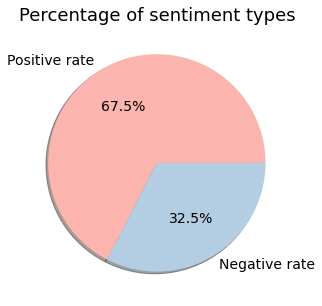

In [64]:
# Percentage of sentiment types for 'sentiment analysis' dataset
fig, ax = plt.subplots(figsize=(5, 5))
y = np.array([Positive_rate, Negative_rate])
mylabels = ["Positive rate", 'Negative rate']

plt.pie(y, labels=mylabels, autopct='%.1f%%', shadow=True, 
              textprops={'fontsize': 14}, 
              colors = sns.color_palette('Pastel1'))
plt.title('Percentage of sentiment types', fontsize=18)

plt.show() 

### 4.1.2 Wordcloud plot for sentiment analysis dataframe

In [65]:
sentiment_entire_str = ' '.join(sentiment["lemmatization"].ravel())
sentiment_positive_str = ' '.join(pos_tweet["lemmatization"].ravel())
sentiment_negative_str = ' '.join(neg_tweet["lemmatization"].ravel())

In [66]:
def wordcloud(entire_str=sentiment_entire_str, positive_str=sentiment_positive_str, 
              negative_str=sentiment_negative_str, 
              title='Most common words | Entire Data',
              subtitle1='Most common words| Positive Labels',
              subtitle2='Most common words| Negative Labels'):
    wordcloud_all = WordCloud(width = 2000, height = 1000, collocations=False, random_state = 7,
                              background_color="black", colormap='Pastel1_r').generate(entire_str) #Pastel1_r
    wordcloud_pos =  WordCloud(width = 1000, height = 1000, collocations=False, random_state = 7,
                               background_color="black", colormap='YlOrRd').generate(positive_str)
    wordcloud_neg =  WordCloud(width = 1000, height = 1000, collocations=False, random_state = 7,
                               background_color="black", colormap='YlGnBu').generate(negative_str)

    fig = plt.figure(figsize=(15, 15), constrained_layout=True)
    spec = fig.add_gridspec(2, 2)

    ax0 = fig.add_subplot(spec[0, :])
    plt.imshow(wordcloud_all)
    plt.title(title, fontsize= 20)
    plt.axis("off")

    ax10 = fig.add_subplot(spec[1, 0])
    plt.imshow(wordcloud_pos)
    plt.title(subtitle1, fontsize= 20)
    plt.axis("off")

    ax11 = fig.add_subplot(spec[1, 1])
    plt.imshow(wordcloud_neg)
    plt.title(subtitle2, fontsize= 20)
    plt.axis("off")

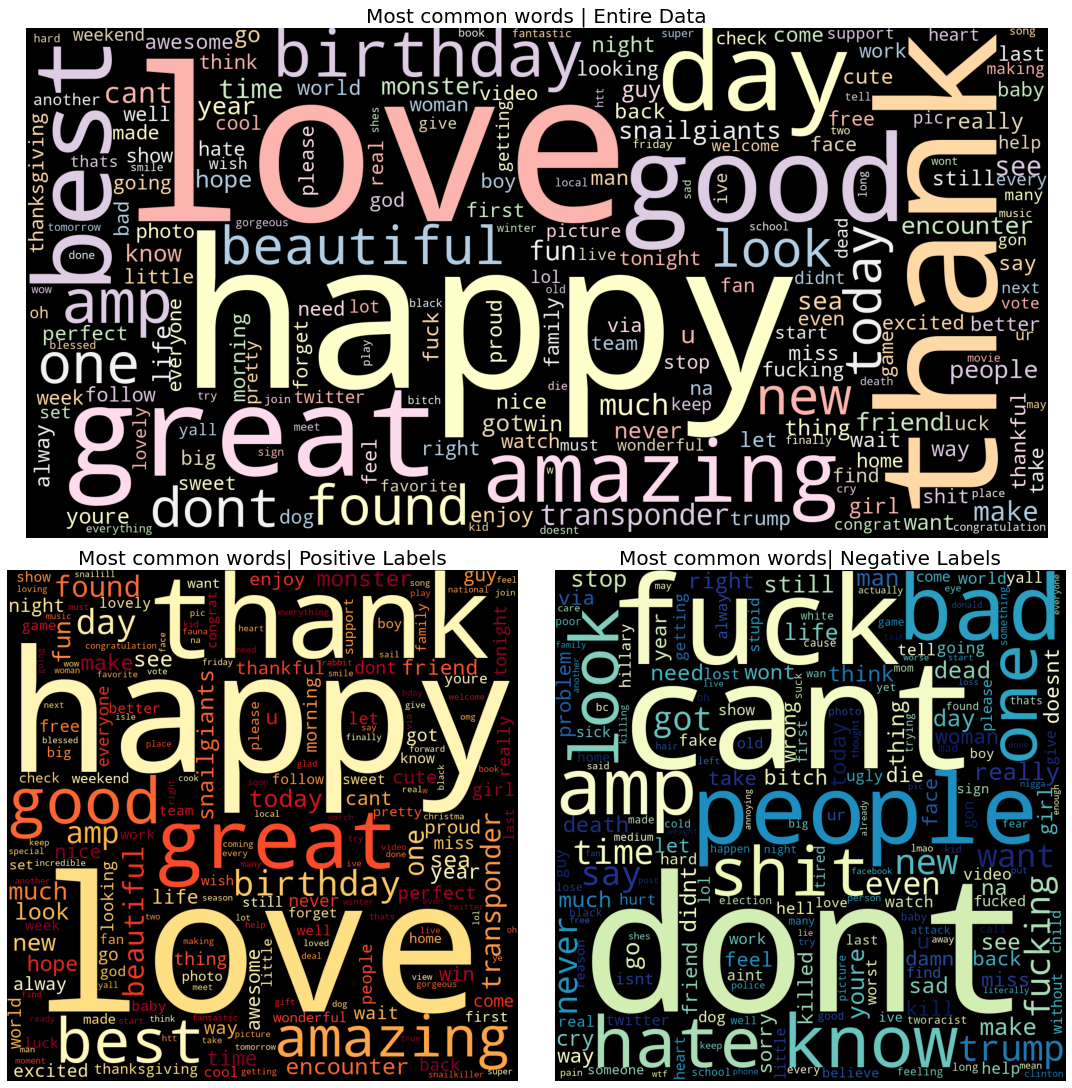

In [67]:
wordcloud(entire_str=sentiment_entire_str, positive_str=sentiment_positive_str, 
          negative_str=sentiment_negative_str, 
          title='Most common words | Entire Data')

### 4.1.3 Compare training and test accuracy in different models

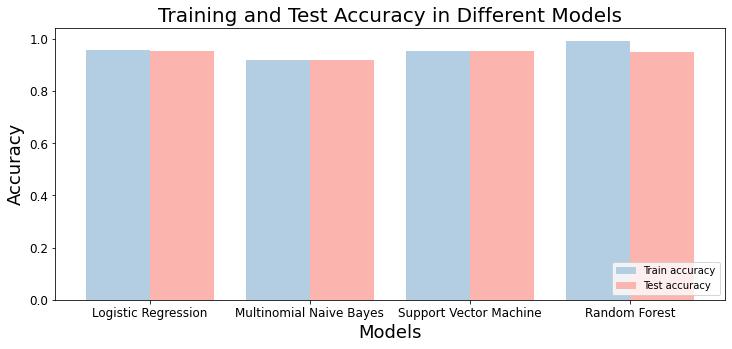

In [68]:
# Four Models in Part1  
X = ['Logistic Regression','Multinomial Naive Bayes','Support Vector Machine','Random Forest']
#train and test accuracy for each model
train_accuracy = [0.9561 , 0.9201, 0.9556, 0.9927]
test_accuracy = [0.9543, 0.919, 0.9537, 0.9517]
#plot the Training and test accuracy in different models 
X_axis = np.arange(len(X))
fig, ax = plt.subplots(figsize=(12, 5)) 
plt.bar(X_axis - 0.2, train_accuracy, 0.4, label = 'Train accuracy', color = '#b3cde3')
plt.bar(X_axis + 0.2,test_accuracy, 0.4, label = 'Test accuracy', color = '#fbb4ae')
  
plt.xticks(X_axis, X)
plt.xlabel("Models",fontsize = 18)
plt.xticks(fontsize=12)
plt.ylabel("Accuracy",fontsize = 18)
plt.yticks(fontsize=12)
plt.title("Training and Test Accuracy in Different Models", fontsize = 20)
plt.legend(loc='lower right')
plt.show()

## 4.2 Plots for Part 2

### 4.2.1 Suggested dataset - '0819_UkraineCombinedTweetsDeduped' 

#### 4.2.1.1 Pie chart for percentage of sentiment types

In [69]:
remove_words = ['ukraine', 'russian', 'russia', 'ukrainian', 'u']
test_data_1['lemmatization2'] = test_data_1['lemmatization'].apply(lambda x: ' '.join(
        [word for word in x.split() if word not in remove_words]))

In [70]:
# rate of postive v.s. negtive
test_data_1_pos_tweet = test_data_1[test_data_1.type == 1]
test_data_1_neg_tweet =  test_data_1[test_data_1.type == 0]
Positive_rate = test_data_1_pos_tweet.shape[0]/test_data_1.shape[0]
Negative_rate = test_data_1_neg_tweet.shape[0]/test_data_1.shape[0]
print('Positive rate:',round(Positive_rate*100,3), "%", 
      '\nNegative rate:',round(Negative_rate*100,3),"%")

Positive rate: 50.546 % 
Negative rate: 49.454 %


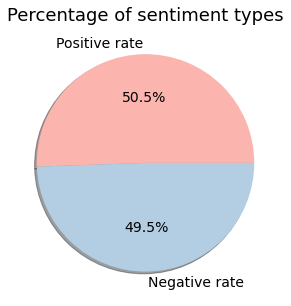

In [71]:
fig, ax = plt.subplots(figsize=(5, 5))
y = np.array([Positive_rate, Negative_rate])
mylabels = ["Positive rate", 'Negative rate']
 
plt.pie(y, labels=mylabels, autopct='%.1f%%', shadow=True, textprops={'fontsize': 14}, 
        colors = sns.color_palette('Pastel1'))
plt.title('Percentage of sentiment types', fontsize=18)
plt.show() 

#### 4.2.1.2 Wordcloud 

In [72]:
test_data_1_entire_str = ' '.join(test_data_1["lemmatization2"].ravel())
test_data_1_positive_str = ' '.join(test_data_1_pos_tweet["lemmatization2"].ravel())
test_data_1_negative_str = ' '.join(test_data_1_neg_tweet["lemmatization2"].ravel())

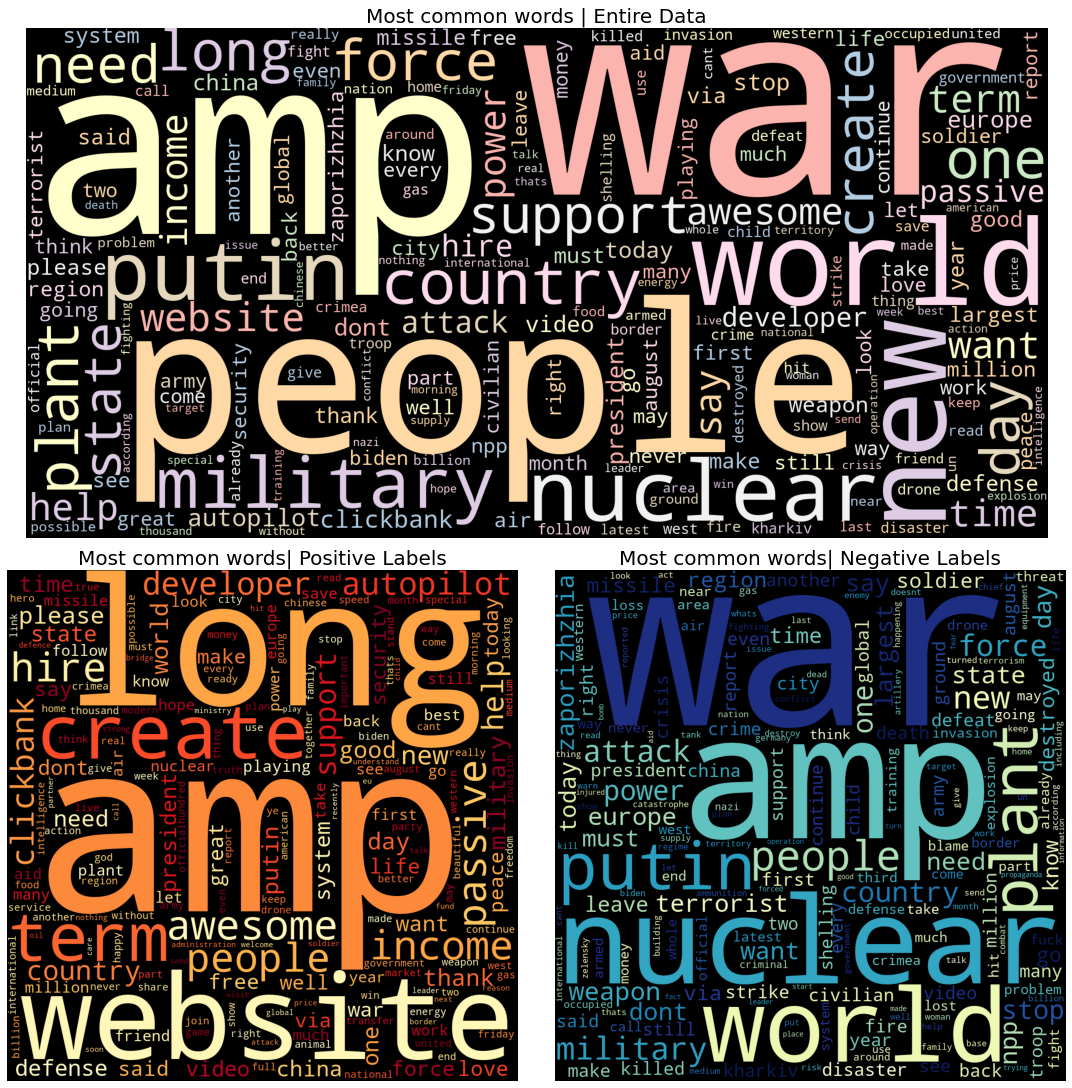

In [73]:
wordcloud(entire_str=test_data_1_entire_str, positive_str=test_data_1_positive_str, 
          negative_str=test_data_1_negative_str, 
          title='Most common words | Entire Data')

### 4.2.2  Our own dataset 'Ukraine_Russia_War' extracted from Twitter

#### 4.2.2.1 Pie chart for percentage of sentiment types

In [74]:
remove_words = ['ukraine', 'russian', 'russia', 'ukrainian', 'u']
test_data_2['lemmatization2'] = test_data_2['lemmatization'].apply(lambda x: ' '.join(
        [word for word in x.split() if word not in (remove_words)]))

In [75]:
# rate of postive v.s. negtive
test_data_2_pos_tweet = test_data_2[test_data_2.type == 1]
test_data_2_neg_tweet =  test_data_2[test_data_2.type == 0]
Positive_rate = test_data_2_pos_tweet.shape[0]/test_data_2.shape[0]
Negative_rate = test_data_2_neg_tweet.shape[0]/test_data_2.shape[0]
print('Positive rate:',round(Positive_rate*100,3), "%", 
      '\nNegative rate:',round(Negative_rate*100,3),"%")

Positive rate: 13.663 % 
Negative rate: 86.337 %


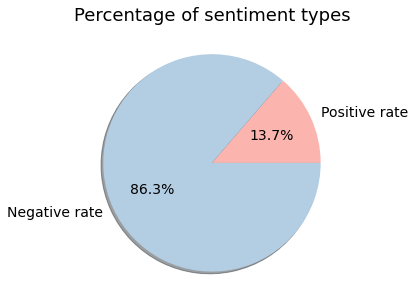

In [76]:
fig, ax = plt.subplots(figsize=(5, 5))
y = [Positive_rate, Negative_rate]
mylabels = ["Positive rate", 'Negative rate']
 
plt.pie(y, labels=mylabels, autopct='%.1f%%', shadow=True, textprops={'fontsize': 14},
        colors = sns.color_palette('Pastel1'))
plt.title('Percentage of sentiment types', fontsize=18)
plt.show() 

#### 4.2.2.2 Wordcloud 

In [77]:
test_data_2_entire_str = ' '.join(test_data_2["lemmatization2"].ravel())
test_data_2_positive_str = ' '.join(test_data_2_pos_tweet["lemmatization2"].ravel())
test_data_2_negative_str = ' '.join(test_data_2_neg_tweet["lemmatization2"].ravel())

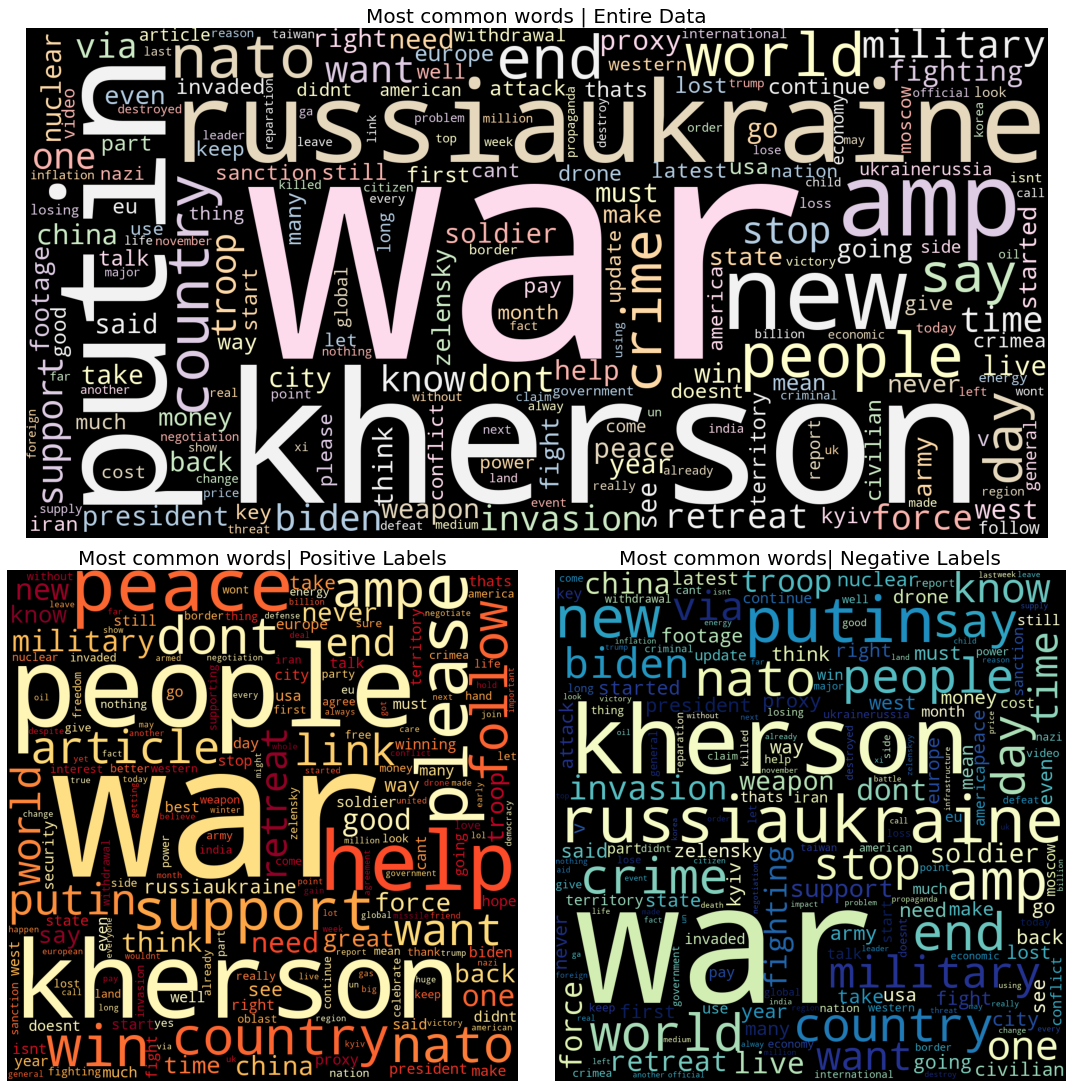

In [78]:
wordcloud(entire_str=test_data_2_entire_str, positive_str=test_data_2_positive_str, 
          negative_str=test_data_2_negative_str, 
          title='Most common words | Entire Data')

## 4.3 Plots for Part 3

### 4.3.1 Negative Topics

#### 4.3.1.1 Negative Topic Probability Pie Chart

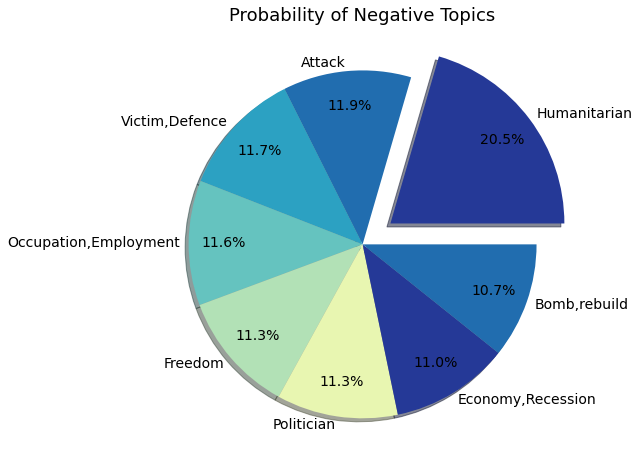

In [79]:
# count each topic
neg_value_counts_df = pd.DataFrame(negative_df['Topic_name'].value_counts())
                           
# Create Topic Probability Pie Chart
fig, ax = plt.subplots(figsize=(8, 8))
y = neg_value_counts_df.iloc[:,0].values
mylabels = neg_value_counts_df.index.tolist()

pie = plt.pie(y, labels=mylabels, autopct='%.1f%%', shadow=True, explode=[0.2,0,0,0,0,0,0,0], 
              textprops={'fontsize': 14}, labeldistance =1.05, pctdistance=0.8,
              colors = sns.color_palette('YlGnBu_r'))
plt.title('Probability of Negative Topics', fontsize=18)
# plt.legend(pie[0],mylabels, bbox_to_anchor=(1.2,0.6), loc="center right", fontsize=10, 
#            bbox_transform=plt.gcf().transFigure)
plt.show() 

#### 4.3.1.2 Negative Topic Count Histogram

In [80]:
# define function to plot topic count
def count_visualization(x_val, y_val, title='title', xlabel='', ylabel='',
                        plt_size=(14, 7), color_palette='Spectral', x_rotate=0, plot_orient='h'):
    
    plt.figure(figsize=plt_size)
    
    plot = sns.barplot(x = x_val, y = y_val, palette=color_palette, orient = plot_orient)
    plot.set_title(title, fontsize=16)
    plot.set_xlabel(xlabel, fontsize=12)
    plot.set_ylabel(ylabel, fontsize=12)
    plt.yticks(fontsize=15)
    
    plt.xticks(rotation=x_rotate)

    plt.show()

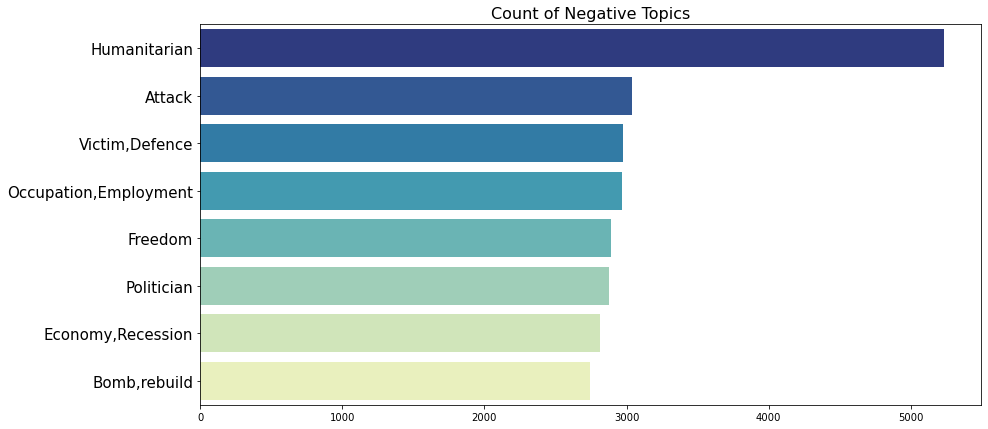

In [81]:
count_visualization(neg_value_counts_df.iloc[:,0].values, neg_value_counts_df.index.tolist(),
                    title='Count of Negative Topics',
                    plt_size=(14, 7), color_palette='YlGnBu_r', 
                    x_rotate=0, plot_orient='h')

### 4.3.2 Positive Topics

#### 4.3.2.1 Positive Topic Probability Pie Chart

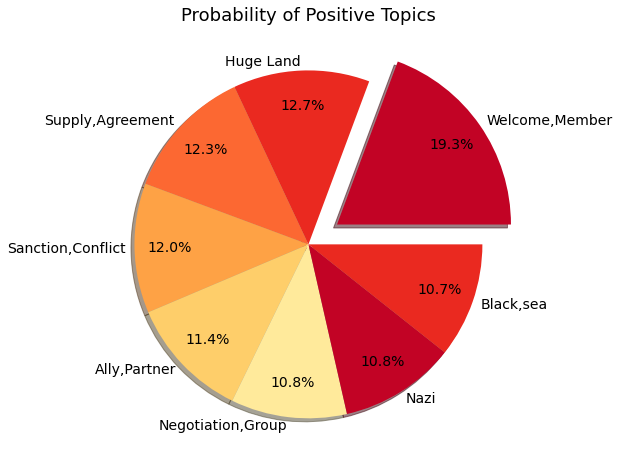

In [82]:
# count each topic
pos_value_counts_df = pd.DataFrame(positive_df['Topic_name'].value_counts())
                           
# Create Topic Probability Pie Chart
fig, ax = plt.subplots(figsize=(8, 8))
y = pos_value_counts_df.iloc[:,0].values
mylabels = pos_value_counts_df.index.tolist()

pie = plt.pie(y, labels=mylabels, autopct='%.1f%%', shadow=True, explode=[0.2,0,0,0,0,0,0,0], 
              textprops={'fontsize': 14}, labeldistance =1.05, pctdistance=0.8,
              colors = sns.color_palette('YlOrRd_r'))
plt.title('Probability of Positive Topics', fontsize=18)
# plt.legend(pie[0],mylabels, bbox_to_anchor=(1.2,0.6), loc="center right", fontsize=10, 
#            bbox_transform=plt.gcf().transFigure)
plt.show() 

#### 4.3.2.2 Positive Topic Count Histogram

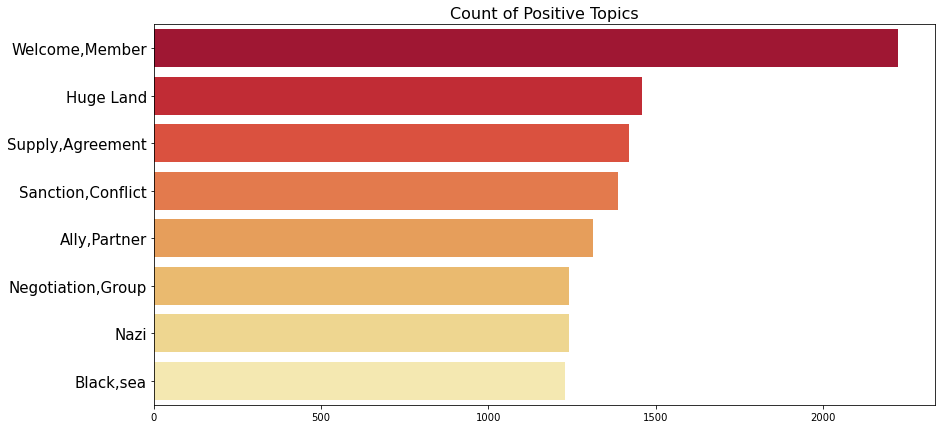

In [83]:
count_visualization(pos_value_counts_df.iloc[:,0].values, pos_value_counts_df.index.tolist(),
                    title='Count of Positive Topics',
                    plt_size=(14, 7), color_palette='YlOrRd_r', 
                    x_rotate=0, plot_orient='h')

### 4.3.3 All Topics

#### 4.3.3.1 All Topic Probability Pie Chart

In [84]:
#concatenate postive and negative dataframe
df_all = pd.concat([positive_df,negative_df],axis = 0)

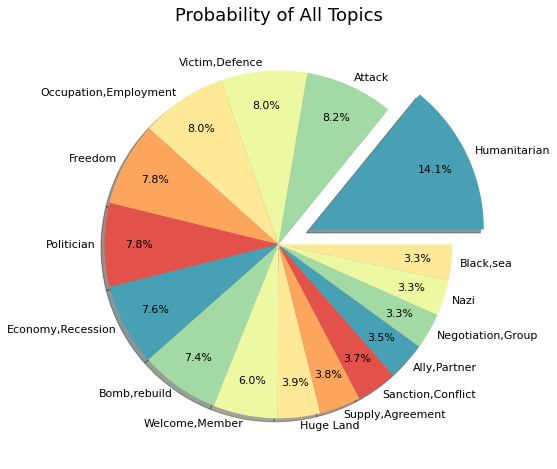

In [85]:
# count each topic
all_value_counts_df = pd.DataFrame(df_all['Topic_name'].value_counts())
                           
# Create Topic Probability Pie Chart
fig, ax = plt.subplots(figsize=(8, 8))
y = all_value_counts_df.iloc[:,0].values
mylabels = all_value_counts_df.index.tolist()

pie = plt.pie(y, labels=mylabels, autopct='%.1f%%', shadow=True, explode=[0.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
              textprops={'fontsize': 11}, labeldistance =1.05, pctdistance=0.8,
              colors = sns.color_palette('Spectral_r'))
plt.title('Probability of All Topics', fontsize=18)
# plt.legend(pie[0],mylabels, bbox_to_anchor=(1.2,0.6), loc="center right", fontsize=10, 
#            bbox_transform=plt.gcf().transFigure)
plt.show() 

#### 4.3.3.2 All Topic Counts Histogram

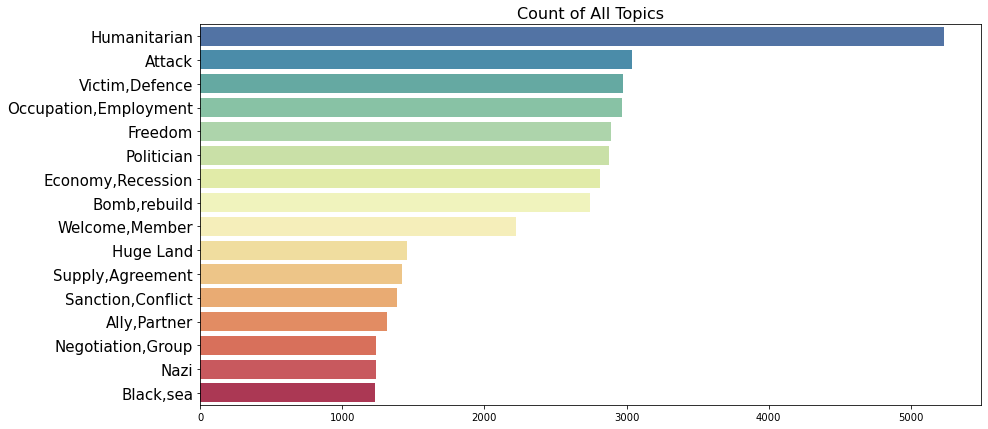

In [86]:
count_visualization(all_value_counts_df.iloc[:,0].values, all_value_counts_df.index.tolist(),
                    title='Count of All Topics',
                    plt_size=(14, 7), color_palette='Spectral_r', 
                    x_rotate=0, plot_orient='h')

### 4.3.4 WordCloud for negative, positive topics a dn all topics

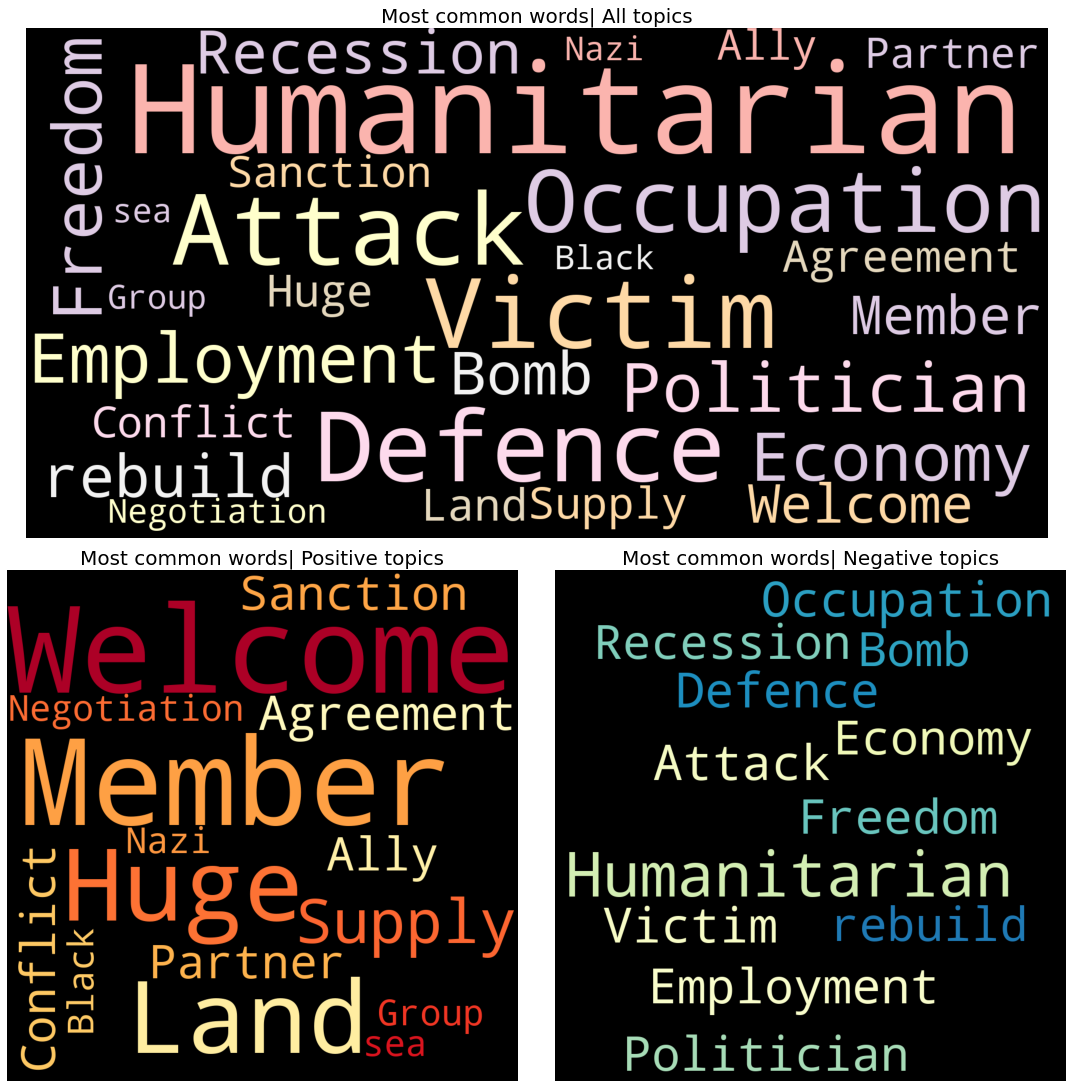

In [87]:
wordcloud(' '.join(df_all['Topic_name'].ravel()), ' '.join(positive_df['Topic_name'].ravel()), 
          ' '.join(negative_df['Topic_name'].ravel()), 
          'Most common words| All topics', 
          'Most common words| Positive topics',
          'Most common words| Negative topics')